# **Google Play Store Apps** - Data Analysis

This notebook includes the procedure of making a descriptive analysis of google play store apps data obtained from [Kaggle](https://www.kaggle.com/datasets/lava18/google-play-store-apps) and cleaned previously.

## 1) Import Libraries

In [3]:
# import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from IPython.display import display_html
from packaging.version import parse, Version, LegacyVersion
from packaging.utils import canonicalize_version
import os, re

## 2) Load Dataframes

In [4]:
# load stored dataframes
%store -r

In [5]:
# full feature dataframe
df_feature.head(3)

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19.0,10000.0,Free,0.0,Everyone,"[Art, Design]",2018.0,1.0,7.0,Sunday,2018-01-07,1,4.0.3
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14.0,500000.0,Free,0.0,Everyone,"[Pretend Play, Art, Design]",2018.0,1.0,15.0,Monday,2018-01-15,2,4.0.3
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510.0,8.7,5000000.0,Free,0.0,Everyone,"[Art, Design]",2018.0,8.0,1.0,Wednesday,2018-08-01,1.2.4,4.0.3


In [6]:
# full review dataframe
df_review.head(3)

,app,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000


In [5]:
# outer merged dataframe
result_outer.head(3)

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,...,update_month,update_day,update_weekday,last_updated,current_ver,android_ver,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity
0,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14M,500000.0,Free,0.0,Everyone,"[Pretend Play, Design, Art]",...,1.0,15.0,Monday,2018-01-15,2,4.0.3,A kid's excessive ads. The types ads allowed a...,Negative,-0.250,1.000000
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14M,500000.0,Free,0.0,Everyone,"[Pretend Play, Design, Art]",...,1.0,15.0,Monday,2018-01-15,2,4.0.3,It bad >:(,Negative,-0.725,0.833333
2,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14M,500000.0,Free,0.0,Everyone,"[Pretend Play, Design, Art]",...,1.0,15.0,Monday,2018-01-15,2,4.0.3,like,Neutral,0.000,0.000000


In [7]:
# average merged dataframe
result_avg.head(3)

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver,sentiment,sentiment_polarity,sentiment_subjectivity
0,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14.0,500000.0,Free,0.0,Everyone,"[Pretend Play, Art, Design]",2018.0,1.0,15.0,Monday,2018-01-15,2,4.0.3,Positive,0.117917,0.645694
1,Garden Coloring Book,ART_AND_DESIGN,4.4,13791.0,33.0,1000000.0,Free,0.0,Everyone,"[Art, Design]",2017.0,9.0,20.0,Wednesday,2017-09-20,2.9.2,3,Positive,0.268483,0.523447
2,FlipaClip - Cartoon animation,ART_AND_DESIGN,4.3,194216.0,39.0,5000000.0,Free,0.0,Everyone,"[Art, Design]",2018.0,8.0,3.0,Friday,2018-08-03,2.2.5,4.0.3,Positive,0.412649,0.679226


In [7]:
result_avg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 816 entries, 0 to 815
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   app                     816 non-null    object        
 1   category                816 non-null    object        
 2   rating                  816 non-null    float64       
 3   reviews                 816 non-null    float64       
 4   size                    816 non-null    object        
 5   installs                816 non-null    float64       
 6   type                    816 non-null    object        
 7   price                   816 non-null    float64       
 8   content_rating          816 non-null    object        
 9   genres                  816 non-null    object        
 10  update_year             816 non-null    float64       
 11  update_month            816 non-null    float64       
 12  update_day              816 non-null    float64   

In [90]:
df_feature.category.value_counts()

FAMILY                 1967
GAME                   1144
TOOLS                   840
MEDICAL                 463
BUSINESS                460
PRODUCTIVITY            424
PERSONALIZATION         390
COMMUNICATION           387
SPORTS                  384
LIFESTYLE               382
FINANCE                 366
HEALTH_AND_FITNESS      341
PHOTOGRAPHY             335
SOCIAL                  295
NEWS_AND_MAGAZINES      283
SHOPPING                260
TRAVEL_AND_LOCAL        258
DATING                  234
BOOKS_AND_REFERENCE     230
VIDEO_PLAYERS           175
EDUCATION               156
ENTERTAINMENT           149
MAPS_AND_NAVIGATION     137
FOOD_AND_DRINK          127
HOUSE_AND_HOME           88
AUTO_AND_VEHICLES        85
LIBRARIES_AND_DEMO       84
WEATHER                  82
EVENTS                   64
ART_AND_DESIGN           64
PARENTING                60
COMICS                   60
BEAUTY                   53
Name: category, dtype: int64

## 3) General Analysis

From this part of the analysis, we can extract some significant data concerning the overall world of apps. 
- which apps are the most downloaded/most popular?
- which are the driving categories? What's the category ranking in terms of installs? And in terms of rating? Does more downloads = better rating? Why?
- do sentiments and ratings combine? Are they consistent?


- on which days are users more likely to download apps? On weekend? Or during weekdays? What could be the reason?
- on which months are users more likely to download apps? And which categories? (eg. diet before summer) What could be the reason?


- which category is associated to the most/least number of apps? In the latter case, how are installs and reviews? Does less associated apps = worse quality? Why?


- what is the average price for paid apps? Use both mean() and median(). There is one or more big outlier(s). Let's see how they affect our statistics and decide whether we want to get rid of it/them or not. (For this specific task, let's use whisker/violin/scatter plots to highlight the outliers (maybe with scatter?) and the std before and after removing them (violin?)). 


- which apps were not updated in year 2018? What was the overall sentiment/pölarity for those apps? Could it mean they were abandoned? Or that they are going to be improved in the future?


- Is there a specific content ranking category that seems to be expressing more negative sentiment towards apps in general? If so, which one(s)?
- Is there an overall correlation between free and positive sentiment or paid and negative sentiment?


- Which apps categories (top 5?) have a larger mean size? Are those categories similar or are they totally differnt?
- Are there outliers or is the distribution homogenous? (great chance o use scatter plots here!)
- Is there any correlation between the size of the app and the installs? Do people overall prefer installing smaller apps?

In [92]:
#top most downloaded apps:
most_to_least_downloaded=result_avg.sort_values(['installs'], ascending=False).head(10)
most_to_least_downloaded

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver,sentiment,sentiment_polarity,sentiment_subjectivity
61,Gmail,COMMUNICATION,4.3,4604324.0,NaN,1.000000e+09,Free,0.0,Everyone,[Communication],2018.0,8.0,2.0,Thursday,2018-08-02,Varies,Varies,Positive,0.058016,0.456138
62,Hangouts,COMMUNICATION,4.0,3419249.0,NaN,1.000000e+09,Free,0.0,Everyone,[Communication],2018.0,7.0,21.0,Saturday,2018-07-21,Varies,Varies,Positive,0.239355,0.525005
478,Facebook,SOCIAL,4.1,78158306.0,NaN,1.000000e+09,Free,0.0,Teen,[Social],2018.0,8.0,3.0,Friday,2018-08-03,Varies,Varies,Negative,-0.005909,0.460871
617,Google,TOOLS,4.4,8033493.0,NaN,1.000000e+09,Free,0.0,Everyone,[Tools],2018.0,8.0,3.0,Friday,2018-08-03,Varies,Varies,Positive,0.260359,0.492744
518,Google Photos,PHOTOGRAPHY,4.5,10858556.0,NaN,1.000000e+09,Free,0.0,Everyone,[Photography],2018.0,8.0,6.0,Monday,2018-08-06,Varies,Varies,Positive,0.187021,0.509305
481,Google+,SOCIAL,4.2,4831125.0,NaN,1.000000e+09,Free,0.0,Teen,[Social],2018.0,7.0,26.0,Thursday,2018-07-26,Varies,Varies,Positive,0.368056,0.469444
587,Google Street View,TRAVEL_AND_LOCAL,4.2,2129689.0,NaN,1.000000e+09,Free,0.0,Everyone,"[Local, Travel]",2018.0,8.0,6.0,Monday,2018-08-06,Varies,Varies,Negative,-0.500000,0.691667
760,Google News,NEWS_AND_MAGAZINES,3.9,877635.0,13.0,1.000000e+09,Free,0.0,Teen,"[News, Magazines]",2018.0,8.0,1.0,Wednesday,2018-08-01,5.2,4.4,Positive,0.093930,0.501439
628,Gboard - the Google Keyboard,TOOLS,4.2,1859115.0,NaN,5.000000e+08,Free,0.0,Everyone,[Tools],2018.0,7.0,31.0,Tuesday,2018-07-31,Varies,Varies,Positive,0.064587,0.517172
707,Dropbox,PRODUCTIVITY,4.4,1861310.0,61.0,5.000000e+08,Free,0.0,Everyone,[Productivity],2018.0,8.0,1.0,Wednesday,2018-08-01,Varies,Varies,Positive,0.236331,0.443636


In [93]:
result_avg.sort_values(['rating'],ascending=False).head()

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver,sentiment,sentiment_polarity,sentiment_subjectivity
12,DMV Permit Practice Test 2018 Edition,AUTO_AND_VEHICLES,4.9,6090.0,27.0,100000.0,Free,0.0,Everyone,"[Auto, Vehicles]",2018.0,7.0,3.0,Tuesday,2018-07-03,1.7,4.2,Positive,0.295660,0.559806
253,Down Dog: Great Yoga Anywhere,HEALTH_AND_FITNESS,4.9,28945.0,12.0,500000.0,Free,0.0,Teen,"[Fitness, Health]",2018.0,5.0,17.0,Thursday,2018-05-17,2.6.1,4.2,Positive,0.291847,0.526837
10,CDL Practice Test 2018 Edition,AUTO_AND_VEHICLES,4.9,7774.0,17.0,100000.0,Free,0.0,Everyone,"[Auto, Vehicles]",2018.0,7.0,3.0,Tuesday,2018-07-03,1.7,4.2,Positive,0.241126,0.477825
234,Home Workout for Men - Bodybuilding,HEALTH_AND_FITNESS,4.8,12705.0,15.0,1000000.0,Free,0.0,Everyone,"[Fitness, Health]",2018.0,7.0,10.0,Tuesday,2018-07-10,1.0.2,4,Positive,0.504387,0.476908
516,FreePrints – Free Photos Delivered,PHOTOGRAPHY,4.8,109500.0,37.0,1000000.0,Free,0.0,Everyone,[Photography],2018.0,8.0,2.0,Thursday,2018-08-02,2.18.2,4.1,Positive,0.446181,0.626680


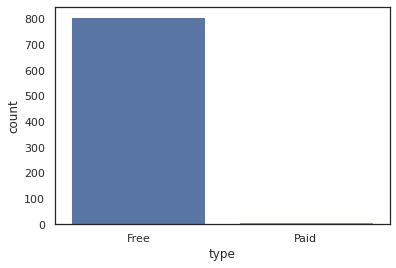

In [94]:
sns.set_theme(style="white")
ax = sns.countplot(x="type", data=result_avg)
plt.show()

#add percentages

## 4) Advanced Analysis

**Business objective: creating a medical app. The app should ideally be for users 17+ and NOT free.**

Business analysis: 
- *SWOT analyses (before and after advanced analysis)* 
- *analysis of competitors*
- *analysis of target users*

(This is an extremely simplified business analysis model as you can guess, but we have limited data availability and we do not have a budgeting plan, nor any specific technical requirements for our app - which heavily affects the considerations we can do about business decisions. That being said, I think we have enough points to analyze, given the objective of the project).

IMPORTANT: the competitors' analysis will be heavily reduced, since we can only analyze the "competitive apps" and not the competitive companies. 

In [95]:
#new dataset with ALL medical apps
df_medical=result_avg[result_avg.category=="MEDICAL"]
df_medical.head()

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver,sentiment,sentiment_polarity,sentiment_subjectivity
445,Essential Anatomy 3,MEDICAL,4.1,1533.0,42.0,50000.0,Paid,11.99,Mature 17+,[Medical],2014.0,8.0,7.0,Thursday,2014-08-07,1.1.3,4.0.3,Positive,0.225516,0.522328
446,Diabetes & Diet Tracker,MEDICAL,4.6,395.0,19.0,1000.0,Paid,9.99,Everyone,[Medical],2018.0,7.0,16.0,Monday,2018-07-16,6.5.1,5,Positive,0.363627,0.568469
447,GoodRx Drug Prices and Coupons,MEDICAL,4.8,59158.0,11.0,1000000.0,Free,0.00,Everyone,[Medical],2018.0,7.0,26.0,Thursday,2018-07-26,5.4.8,4.1,Positive,0.252471,0.449028
448,FollowMyHealth®,MEDICAL,4.6,73118.0,37.0,1000000.0,Free,0.00,Everyone,[Medical],2018.0,5.0,10.0,Thursday,2018-05-10,3.3,4.4,Positive,0.189428,0.481780
449,Blood Pressure,MEDICAL,4.2,33033.0,7.4,5000000.0,Free,0.00,Everyone,[Medical],2018.0,7.0,24.0,Tuesday,2018-07-24,3.27.3,4.1,Positive,0.440863,0.575804


# 1.4.1 - SWOT Analysis (before advanced analysis)

In this section we will quickly go through the Strenghts, Weaknesses, Opportunities and Threats, based on the information we have gathered through the general analysis of the dataset.

- Strenghts:    to be filled
- Weaknesses:    to be filled 
- Opportunities:   to be filled
- Threads:     to be filled

# 1.4.2 Competitors' Analysis

- Top rated PAID apps: which categories? Any medical/health app included?


- Top rated PAID medical/health apps: what is the ranking? And the sentiment? Are the users generally happy about those apps?
- Top rated NON PAID medical/health apps: what is the ranking? And the sentiment? Are the users generally happy about those apps? 
- COMPARE THE TWO PREVIOUS POINTS AND DRAW CONCLUSIONS


- Top rated PAID medical/health apps: when were they last updated? With this, we can understand whether these apps are recent or not. We can also check which are the, say, top 3 paid apps that have not been updated in 2017 and figure out if they still exist or not - and therefore if we should consider them as competition or not. 

# 1.4.3 - Target Users' Analysis

- What is the most common content rating for medical apps? Does it make any sense to restrict it to 17+ or should we review this decision? (also review the various type of content rating

- Is there a correlation between Paid/17+ apps? Or Free/Everyone app? What is the Paid/whichever category below 17 app? So, are 17+ people more willing to spend money for apps?

- 

# 1.4.4 - SWOT Analysis (after advanced analysis)

In this section we will list Strenghts, Weaknesses, Opportunities and Threats, based on the information we have gathered through the advanced analysis of the dataset. Afterwards, we can compare our new SWOT analysis to the older one and we can draw conclusions.

- Strenghts:    to be filled
- Weaknesses:    to be filled 
- Opportunities:   to be filled
- Threads:     to be filled

# 1.5 - Conclusions